## Importing Libraries

In [1]:
import tensorflow as tf
import os
import PIL
from tensorflow.keras import datasets, layers, models
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
#import visualkeras
from keras.applications import InceptionV3
from tensorflow.keras import datasets,models,layers,Sequential
from sklearn.metrics import classification_report, confusion_matrix

2024-03-18 11:14:00.533489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 11:14:00.533603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 11:14:00.670399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def plot_metrics(history,title) :

    """ Plots training and validation loss and accuracy curves for a given training history.

  Args:
      history: A dictionary containing the training history returned by a Keras model's `fit` method.
          It should contain keys like 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.
      title: The title to display on the plots.

  Returns:
      None. This function displays the loss and accuracy plots and does not return any value.
  """

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    index_acc = np.argmax(val_acc)
    val_lowest = val_loss[index_loss]
    val_highest = val_acc[index_acc]

    epochs = [i+1 for i in range(len(train_acc))]
    loss_label = f'Best Epoch = {str(index_loss + 1)}'
    acc_loss = f'Best Epoch = {str(index_acc +1)}'

    #Training Accuracy
    plt.figure(figsize= (20,8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1,2,1)
    plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
    plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
    plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
    plt.title(f'{title} (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
    plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
    plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
    plt.title(f'{title} (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    # Save the plot as a PNG file
    plt.savefig(title + '.png')
    plt.show()

In [3]:
def image_to_array(directory, image_size , info=False):

    """Loads, resizes, and normalizes images from a directory, and encodes labels.

  Args:
      directory: The path to the directory containing subfolders for each image category.
      image_size: A tuple (width, height) for resizing the images.
      info (bool, optional): If True, prints information about the loaded images and classes. Defaults to False.

  Returns:
      A tuple of NumPy arrays (data, labels, encoded_labels):
          - data: A 4D array of shape (num_images, image_height, image_width, channels) containing the normalized images.
          - labels: A 1D array of shape (num_images) containing the original category labels as strings.
          - encoded_labels: A 1D array of shape (num_images) containing the encoded numerical labels.
  """

    data = []
    labels = []
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)
        label = category
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)
            # reading and resizing
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            # normalising images
            image_array = image_array / 255.0
            data.append(image_array)
            labels.append(label)
    # label encoding
    encoded_lab = le.fit_transform(labels)
    # print information about data :
    if info :
        print(f"{len(data)} images found coming from {len(set(labels))} classes")
    return np.array(data),np.array(labels),np.array(encoded_lab)

In [4]:
def compare_models(history_list,labels) :
    """Plots validation accuracy and loss curves for comparison of multiple models.

  Args:
      history_list: A list of training history objects returned by Keras models' `fit` method.
          Each history object should contain keys like 'val_accuracy' and 'val_loss'.
      labels: A list of labels for each model in `history_list`. These labels will be used in the plots.

  Returns:
      None. This function creates a Matplotlib figure with subplots displaying the curves and does not return a value.
  """

    plt.figure(figsize= (20,8))
    plt.suptitle("Comparing Models Performances", fontsize=16)
    i = 0
    for history in history_list :
        plt.subplot(1,2,1)
        plt.plot(history.history["val_accuracy"],label=f"{labels[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.xlim(0,7)
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(history.history["val_loss"],label=f"{labels[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.xlim(0,7)
        plt.legend()
        i += 1
        
    # Save the plot as a PNG file
    plt.savefig("Comparing Models Performances.png")

In [5]:
def compare_conf_mat(models,test_img ,test_lbl, titles) :

    """Generates and compares confusion matrices for multiple models on a given test set.

  Args:
      models: A list of Keras models to compare.
      test_img: A NumPy array of test images.
      test_lbl: A NumPy array of corresponding test labels.
      titles: A list of titles for each model's confusion matrix subplot.

  Returns:
      None. This function creates a Matplotlib figure with subplots displaying confusion matrices and does not return a value.
  """
    labels = list(encoded_categories)
    plt.figure(figsize=(20, 10))
    i = 1
    for model in models :
        predictions = model.predict(test_img)
        # Convert predictions to class labels
        predicted_classes = np.argmax(predictions, axis=1)
        cm = confusion_matrix(test_lbl, predicted_classes)
        plt.subplot(2,3,i)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{titles[i-1]} Confusion Matrix")
        i+=1
    # Save the plot as a PNG file
    plt.savefig("Confusion Matrix.png")

In [6]:
def plot_predictions(model,title) :
    """Visualizes a model's predictions on a sample of images.

  Args:
      model: A trained Keras model capable of image classification.
      title: A string to be used as the overall title of the plot.

  Returns:
      None. This function creates a Matplotlib figure displaying images and predictions and does not return a value.
  """
    pred_images = []

    # looping through our prediction data and transforming in it into array format
    for image_name in os.listdir(pred_dir)[30:40]:
                image_path = os.path.join(pred_dir, image_name)
                # reading and resizing
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                # normalising images
                image_array = image_array / 255.0
                pred_images.append(image_array)
    pred_images = np.array(pred_images)

    # getting the prediction array
    predictions = model.predict(pred_images)
    predictions_indices = np.argmax(predictions, axis = 1)

    # plotting our image predictions
    fig,ax = plt.subplots(2,5,figsize=(15,7))
    i = 0
    plt.style.use('ggplot')
    plt.suptitle(title)
    for image in pred_images :
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.title(encoded_categories[predictions_indices[i]])
        plt.grid(False)
        i+=1
    # Save the plot as a PNG file
    plt.savefig(title+ ".png")

In [7]:
# Initialising data
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
le = preprocessing.LabelEncoder()
classes = 6
image_size = (150,150)

## Data Preprocessing

In [8]:
# trnsforming our images into array format
train_images, train_labels, train_lab_encoded = image_to_array(train_dir, image_size,True)
test_images, test_labels , test_lab_encoded = image_to_array(test_dir, image_size,True)
# getting the classes labels
encoded_categories = le.classes_

14034 images found coming from 6 classes
3000 images found coming from 6 classes


# Modelling :
In this part we will go through the different CNN version that we created from scratch and using transfer learning with different versions compare the results including fine-tuning :

* **Simple CNN**
* **Deep CNN**
* **Deep CNN + Fine-tuning**
* **Inception V1**
* **Inception V2**
* **Inception V3**

## I - Simple CNN :

In [9]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,431,494 (85.57 MB)

 Trainable params: 22,431,494 (85.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model1.compile("adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
history1 = model1.fit(train_images, train_lab_encoded,
                    epochs=10,
                    validation_data=(test_images, test_lab_encoded))

Epoch 1/10


2024-03-18 11:15:35.764157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 7.01362, expected 6.05938
2024-03-18 11:15:35.764220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.59738, expected 5.64314
2024-03-18 11:15:35.764229: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.60386, expected 6.64961
2024-03-18 11:15:35.764237: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.47181, expected 6.51757
2024-03-18 11:15:35.764252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.76316, expected 6.80892
2024-03-18 11:15:35.764261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.80827, expected 5.85402
2024-03-18 11:15:35.764268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.93282, expected 5.97858
2024-03-18 11:15:35.764276: E external/local_xla/xla/se

 16/439 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1719 - loss: 17.7255

I0000 00:00:1710760537.963206      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


436/439 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4336 - loss: 3.4851

2024-03-18 11:15:43.138615: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21912: 5.85239, expected 5.10668
2024-03-18 11:15:43.138698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21914: 6.2359, expected 5.4902
2024-03-18 11:15:43.138708: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21929: 6.20175, expected 5.45605
2024-03-18 11:15:43.138717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21933: 5.83584, expected 5.09013
2024-03-18 11:15:43.138725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21934: 5.39638, expected 4.65067
2024-03-18 11:15:43.138734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21935: 6.10236, expected 5.35665
2024-03-18 11:15:43.138744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21936: 6.34823, expected 5.60252
2024-03-18 11:15:43.138753: E

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4345 - loss: 3.4721

2024-03-18 11:15:48.157422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 71870: 3.97076, expected 3.46381
2024-03-18 11:15:48.157568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81805: 3.97076, expected 3.46381
2024-03-18 11:15:48.157862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109548: 5.23975, expected 4.60528
2024-03-18 11:15:48.157916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109696: 5.20141, expected 4.56694
2024-03-18 11:15:48.157939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109711: 5.2017, expected 4.56723
2024-03-18 11:15:48.157969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109721: 5.25659, expected 4.62213
2024-03-18 11:15:48.157984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109722: 5.13894, expected 4.50447
2024-03-18 11:15:48.157

439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.4348 - loss: 3.4678 - val_accuracy: 0.6543 - val_loss: 0.9342
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7707 - loss: 0.6459 - val_accuracy: 0.7263 - val_loss: 0.7569
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8811 - loss: 0.3653 - val_accuracy: 0.7270 - val_loss: 0.7765
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9496 - loss: 0.1843 - val_accuracy: 0.7480 - val_loss: 0.8672
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9806 - loss: 0.0829 - val_accuracy: 0.7417 - val_loss: 0.9718
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9921 - loss: 0.0452 - val_accuracy: 0.7253 - val_loss: 1.1006
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9900 - loss: 0.0487 - val_accuracy: 0.7280 - val_loss: 1.1613
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9916 - loss: 0.0440 - val_accuracy: 0.70

In [12]:
model1.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6674 - loss: 1.5246


[1.4773746728897095, 0.6919999718666077]

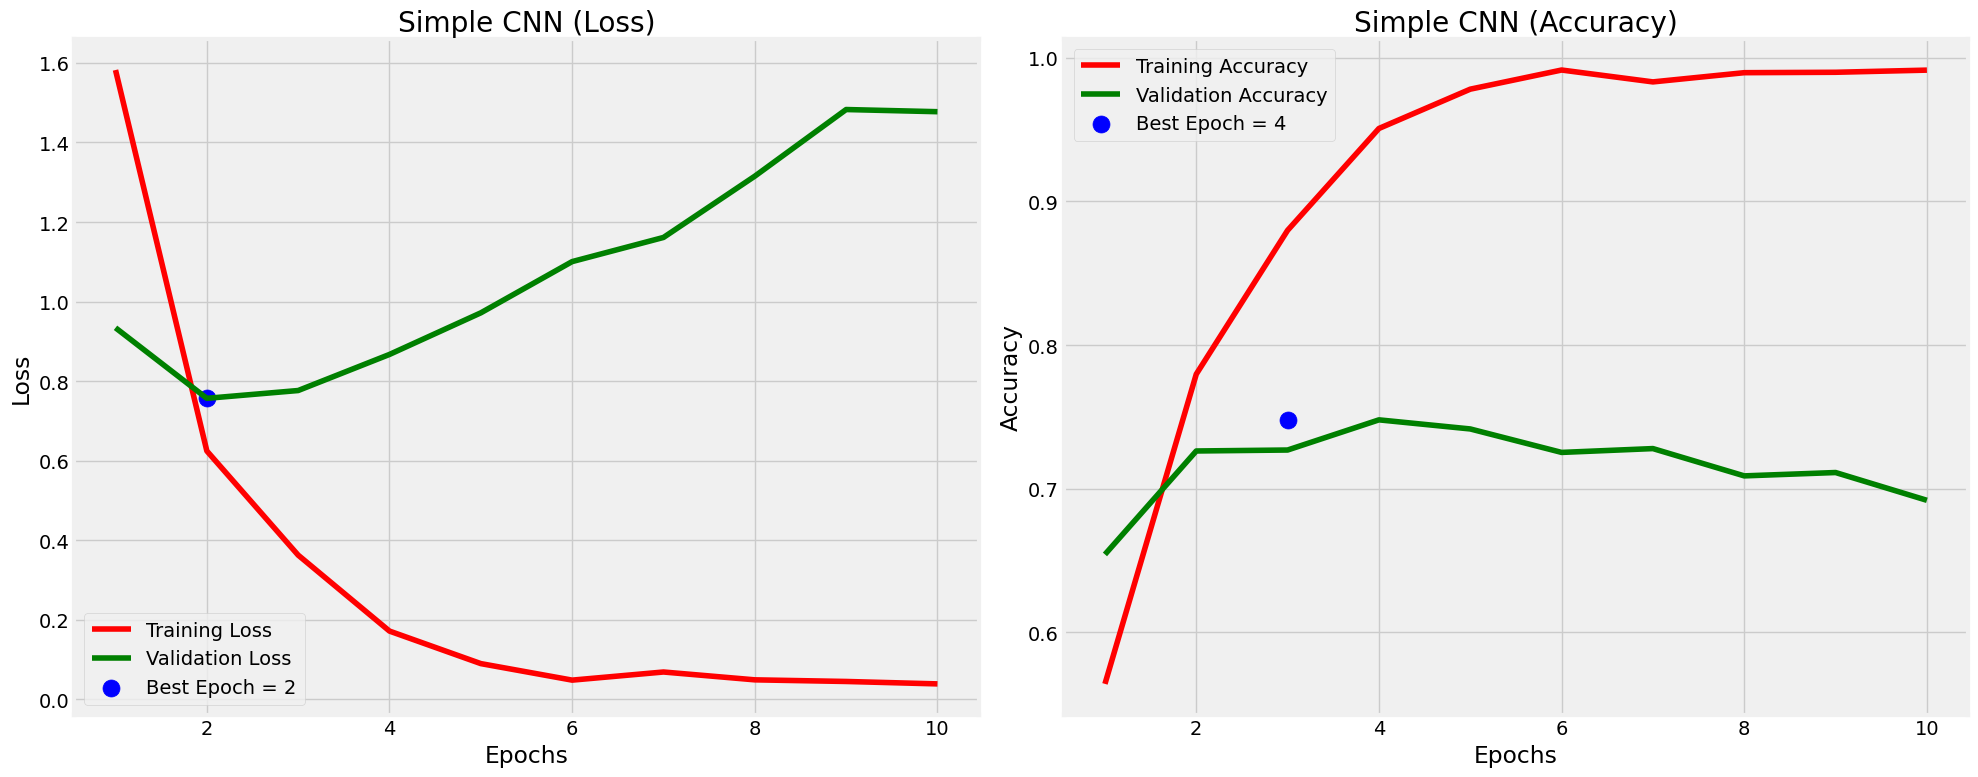

In [13]:
plot_metrics(history1,"Simple CNN")

2024-03-18 11:16:43.611726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.84546, expected 6.04458
2024-03-18 11:16:43.611784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 6.53794, expected 5.73706
2024-03-18 11:16:43.611802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.51572, expected 5.71485
2024-03-18 11:16:43.611821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 37: 6.55851, expected 5.75764
2024-03-18 11:16:43.611837: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38: 6.92338, expected 6.1225
2024-03-18 11:16:43.611848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44: 6.79073, expected 5.98985
2024-03-18 11:16:43.611858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 53: 6.81789, expected 6.01701
2024-03-18 11:16:43.611870: E external/local_xla/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


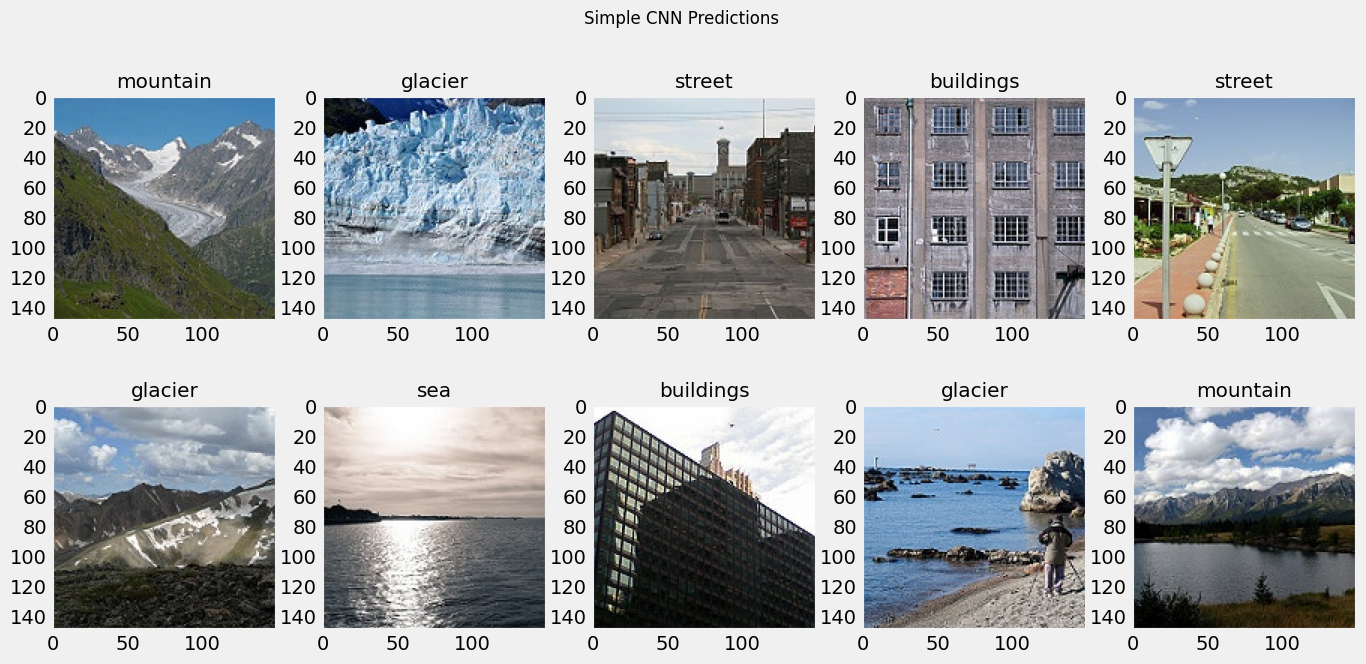

In [14]:
plot_predictions(model1,"Simple CNN Predictions")

## II - Deep CNN :

In [15]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,086 (3.49 MB)

 Trainable params: 914,086 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model2.compile("adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history2 = model2.fit(train_images, train_lab_encoded,
                    epochs=10,
                    validation_data=(test_images, test_lab_encoded))

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5129 - loss: 1.2330 - val_accuracy: 0.6167 - val_loss: 1.0525
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6691 - loss: 0.8722 - val_accuracy: 0.6680 - val_loss: 0.8666
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7062 - loss: 0.7815 - val_accuracy: 0.7183 - val_loss: 0.7661
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7383 - loss: 0.7036 - val_accuracy: 0.6407 - val_loss: 1.1597
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7383 - loss: 0.7182 - val_accuracy: 0.7003 - val_loss: 0.8004
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7444 - loss: 0.6795 - val_accuracy: 0.7500 - val_loss: 0.7142
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7618 - loss: 0.6489 - val_accuracy: 0.7360 - val_loss: 0.7749
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7971 - loss: 0.5614 - val_acc

In [18]:
model2.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7292 - loss: 0.7965


[0.7139409780502319, 0.7673333287239075]

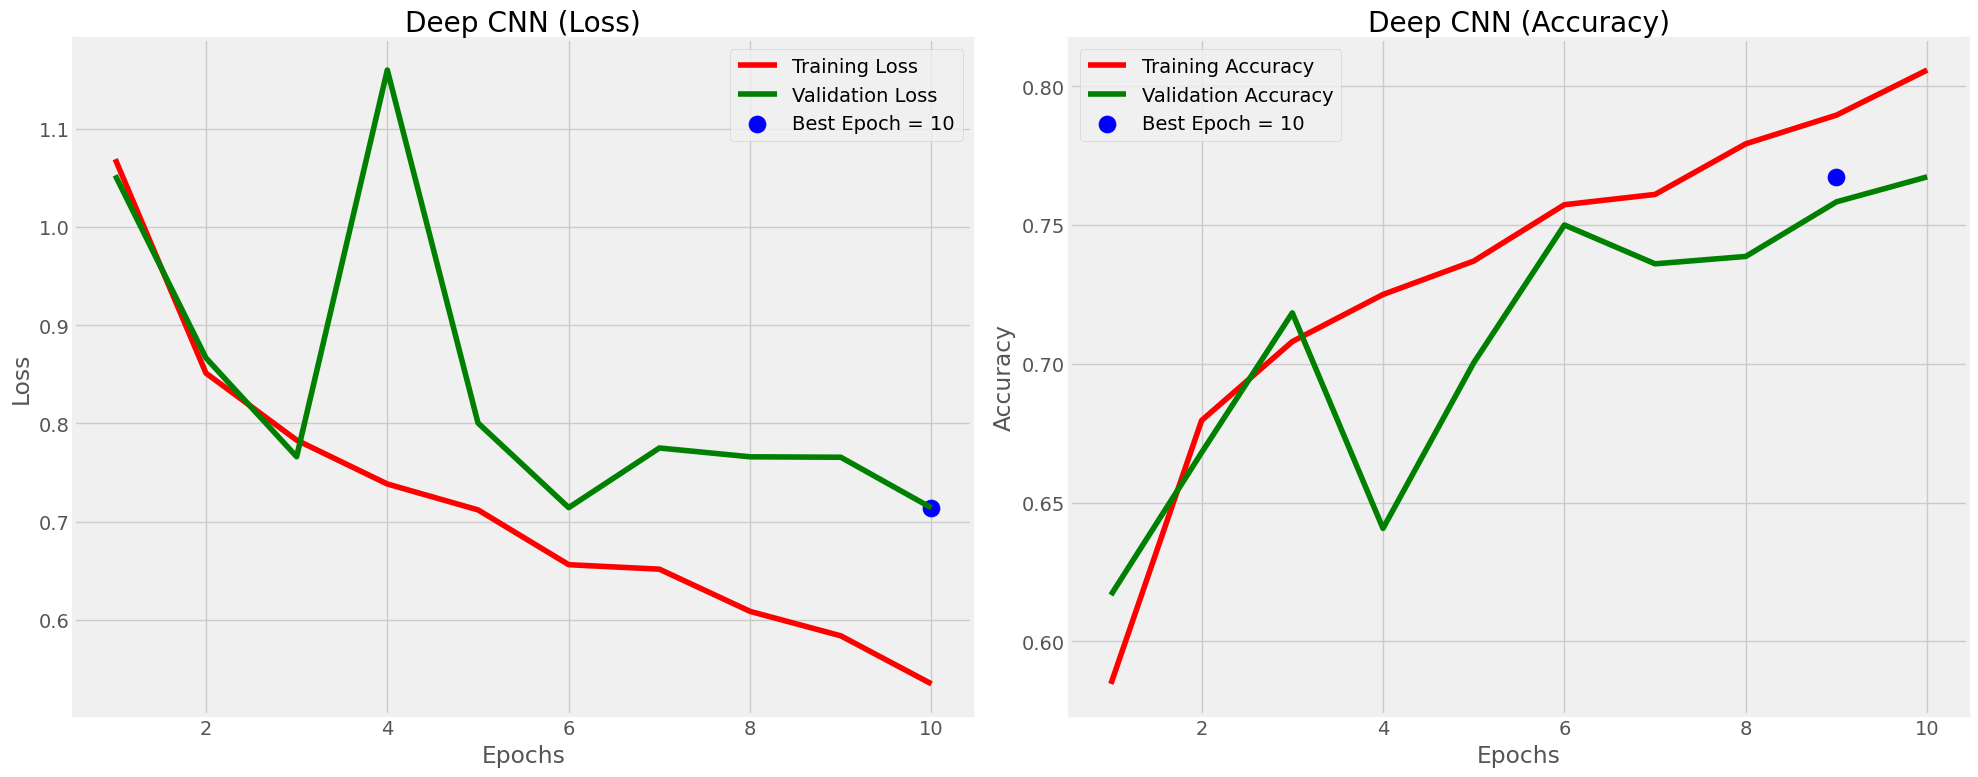

In [19]:
plot_metrics(history2,"Deep CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


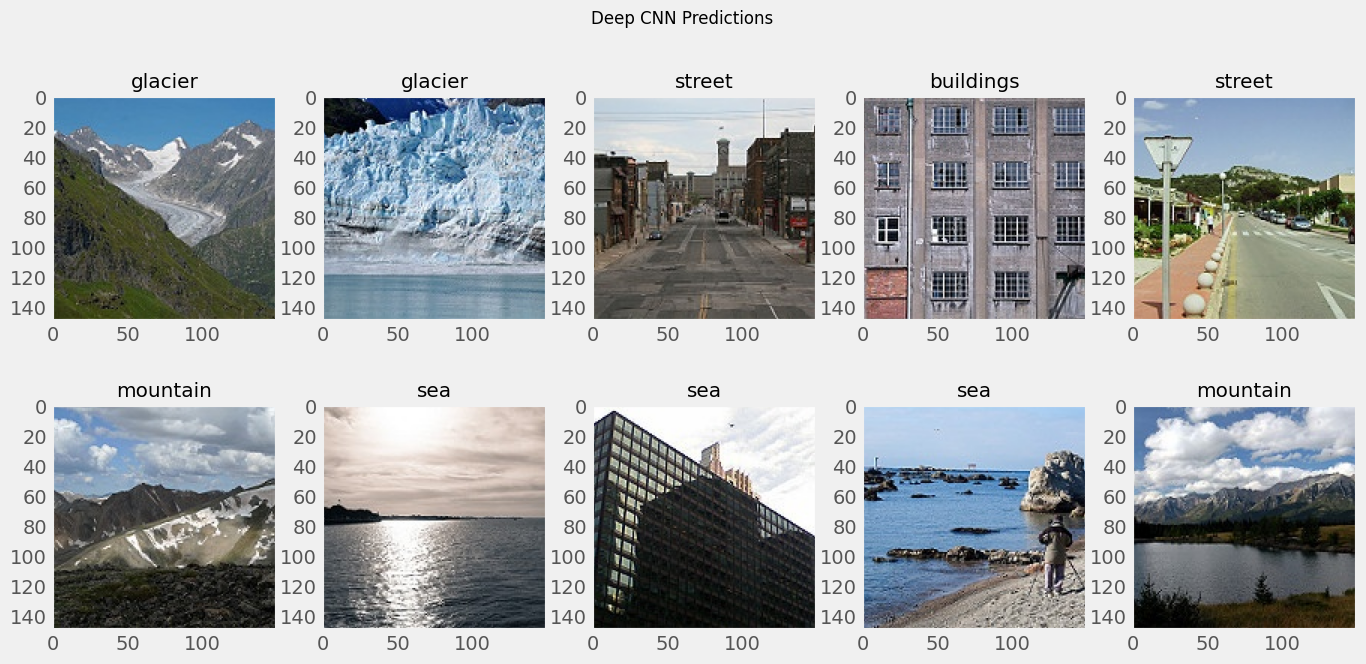

In [20]:
plot_predictions(model2,"Deep CNN Predictions")

## III - Deep CNN + Fine-Tuning

In [21]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,750 (1.81 MB)

 Trainable params: 475,750 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model3.compile(tf.keras.optimizers.Adamax() , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
# Train the model
history3 = model3.fit(train_images, train_lab_encoded,
                    epochs=20,
                    validation_data=(test_images, test_lab_encoded),
                    callbacks=[reduce_lr,early])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5143 - loss: 1.2119 - val_accuracy: 0.6853 - val_loss: 0.8174 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7011 - loss: 0.7940 - val_accuracy: 0.7050 - val_loss: 0.7945 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7621 - loss: 0.6472 - val_accuracy: 0.7287 - val_loss: 0.7326 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7812 - loss: 0.5965 - val_accuracy: 0.7700 - val_loss: 0.6309 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7971 - loss: 0.5487 - val_accuracy: 0.7870 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8211 - loss: 0.5117 - val_accuracy: 0.7803 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8302 - loss: 0

In [24]:
model3.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8262 - loss: 0.5018


[0.49414756894111633, 0.8306666612625122]

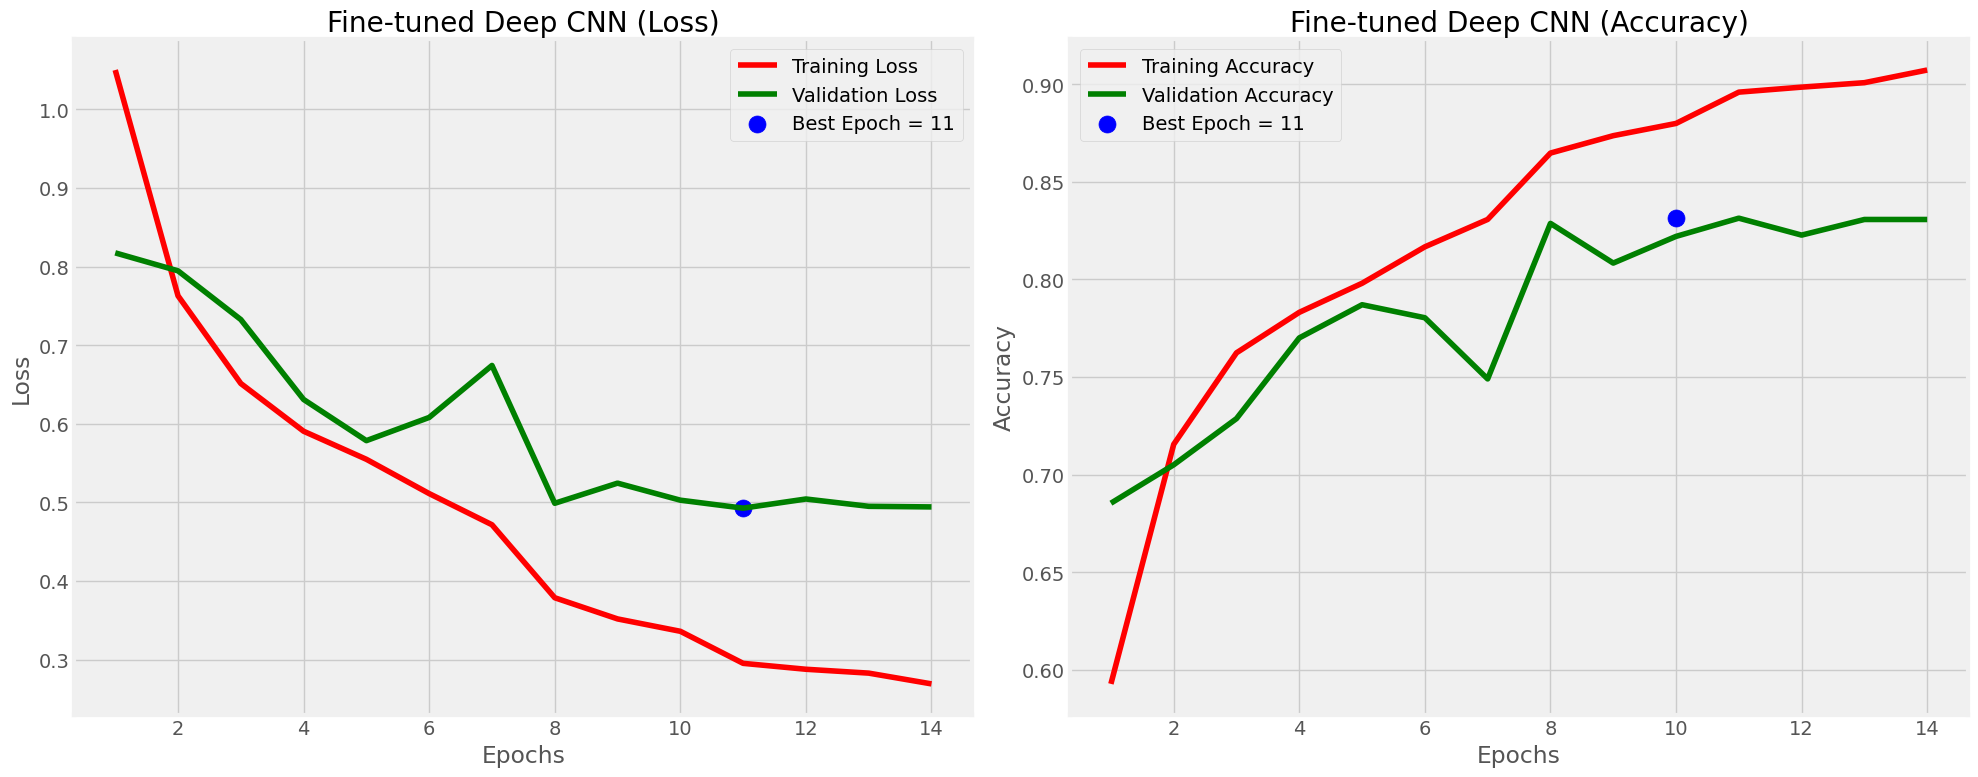

In [25]:
plot_metrics(history3,"Fine-tuned Deep CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


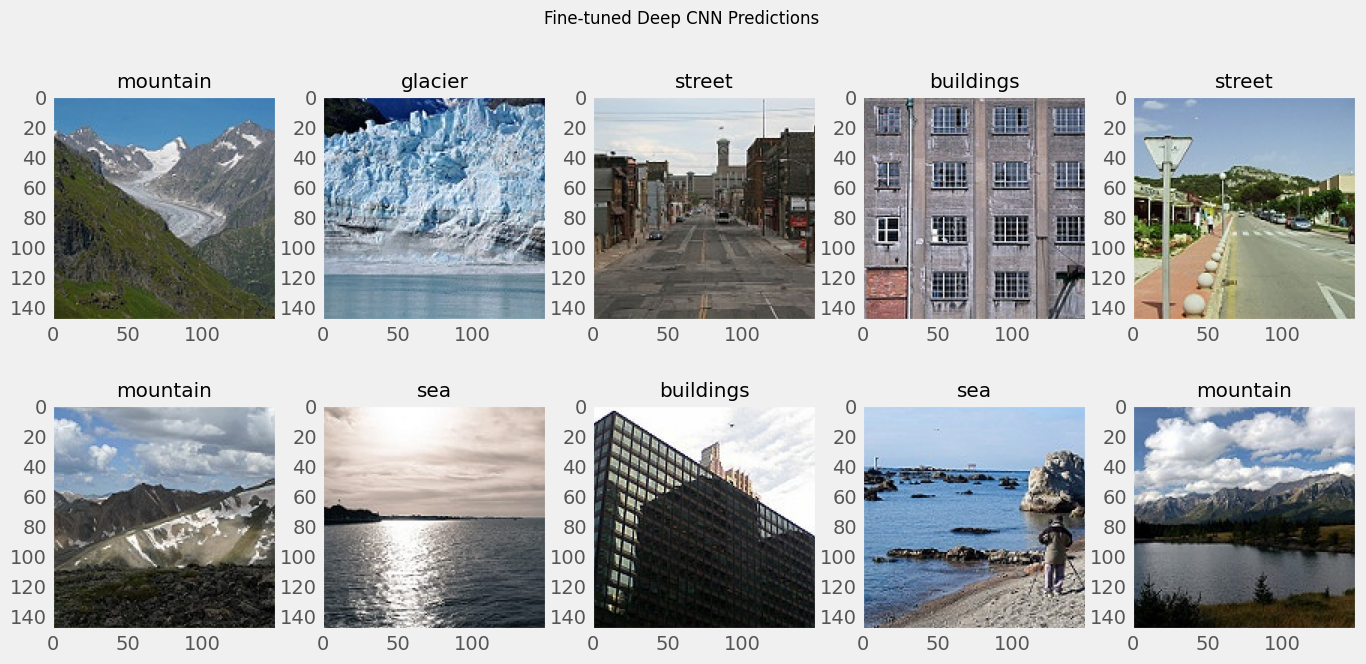

In [26]:
plot_predictions(model3,"Fine-tuned Deep CNN Predictions")

## IV - Inception V1 :
This represents the first version of Inception

In [27]:
# Load InceptionV3 pre-trained on ImageNet
inception1 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception1.layers:
    layer.trainable = False

# Unfreeze the last 25 layers for fine-tuning
for layer in inception1.layers[-25:]:
    layer.trainable = True

last_layer1 = inception1.get_layer('mixed7')
last_output1 = last_layer1.output

# Add custom classification head
x1 = layers.Flatten()(last_output1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)
pred1=layers.Dense(classes,activation="softmax")(x1)
# Create the fine-tuned model
model4 = models.Model(inputs=inception1.input, outputs=pred1)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [28]:
# compile the model
model4.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history4 = model4.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8467 - loss: 0.4288 - val_accuracy: 0.9067 - val_loss: 0.2456
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9398 - loss: 0.1752 - val_accuracy: 0.9097 - val_loss: 0.2522
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9664 - loss: 0.1140 - val_accuracy: 0.9137 - val_loss: 0.2455
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9778 - loss: 0.0765 - val_accuracy: 0.9173 - val_loss: 0.2449
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9879 - loss: 0.0505 - val_accuracy: 0.9133 - val_loss: 0.2536
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9947 - loss: 0.0342 - val_accuracy: 0.9123 - val_loss: 0.2866
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9968 - loss: 0.0268 - val_accuracy: 0.9163 - val_loss: 0.2765
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9985 - loss: 0.0168 - 

In [30]:
model4.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8903 - loss: 0.3124


[0.24493657052516937, 0.9173333048820496]

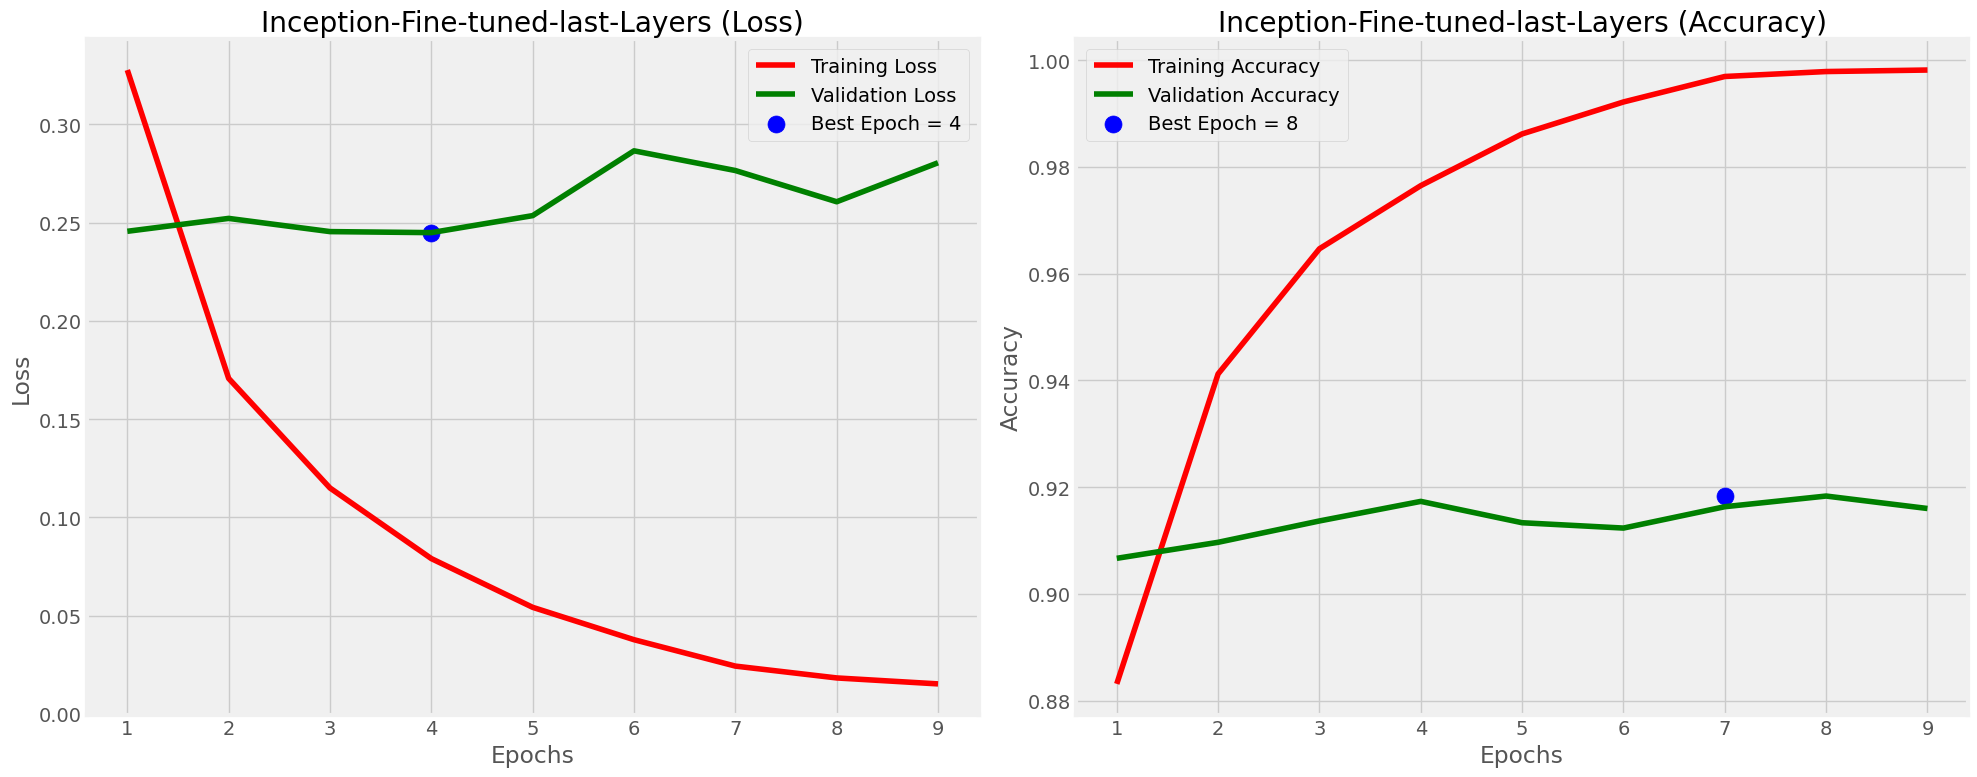

In [31]:
plot_metrics(history4,"Inception-Fine-tuned-last-Layers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


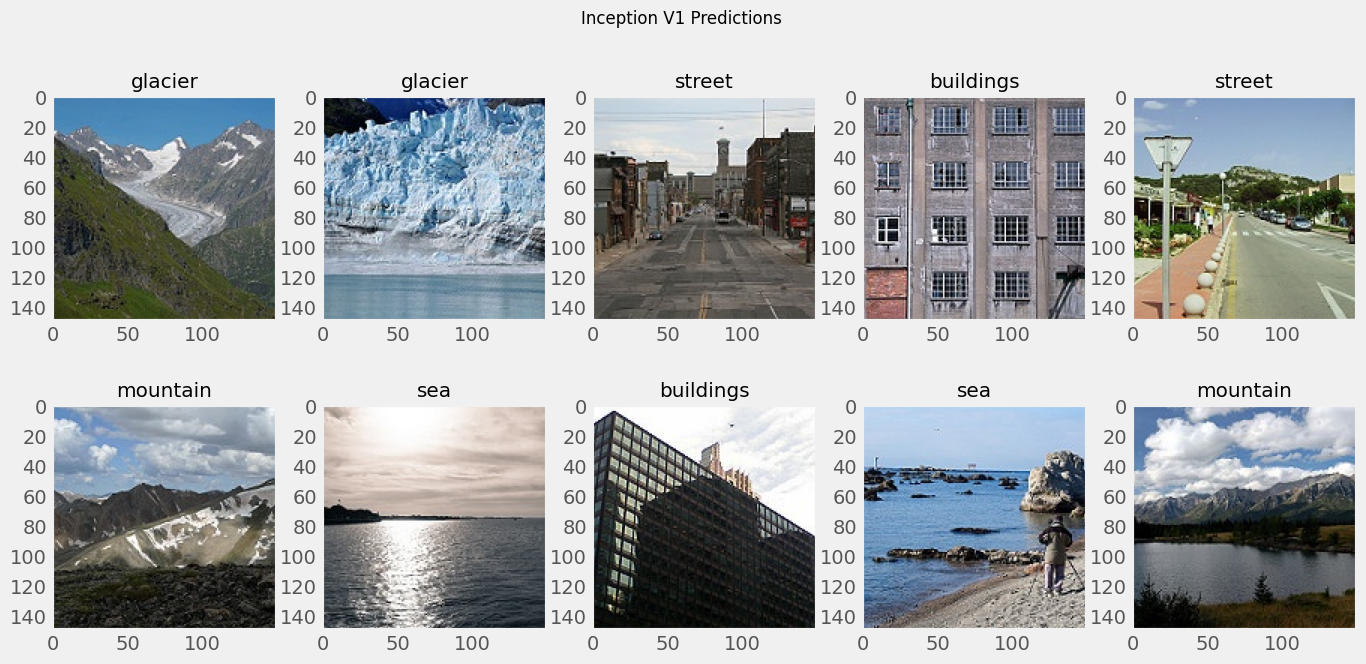

In [32]:
plot_predictions(model4,"Inception V1 Predictions")

## V - Inception V2 :

In [33]:
# Loading InceptionV3 pre-trained on ImageNet
inception2 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False)

# Freezing layers of the pre-trained model
for layer in inception2.layers:
    layer.trainable = False

# Unfreezing the first 25 layers for fine-tuning
for layer in inception2.layers[25:]:
    layer.trainable = True

last_layer2 = inception2.get_layer('mixed7')
last_output2 = last_layer2.output

# Adding custom classification architecture
x2 = layers.Flatten()(last_output2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)
pred2=layers.Dense(classes,activation="softmax")(x2)
# Create the fine-tuned model
model5 = models.Model(inputs=inception2.input, outputs=pred2)

In [34]:
# compile the model
model5.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history5 = model5.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 108s 135ms/step - accuracy: 0.8196 - loss: 0.5158 - val_accuracy: 0.9123 - val_loss: 0.2403
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.9612 - loss: 0.1211 - val_accuracy: 0.9137 - val_loss: 0.2451
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.9886 - loss: 0.0523 - val_accuracy: 0.9167 - val_loss: 0.2487
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9948 - loss: 0.0296 - val_accuracy: 0.9157 - val_loss: 0.2942
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9966 - loss: 0.0163 - val_accuracy: 0.9127 - val_loss: 0.3177
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9177 - val_loss: 0.3237


In [36]:
model5.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8757 - loss: 0.3392


[0.24034498631954193, 0.9123333096504211]

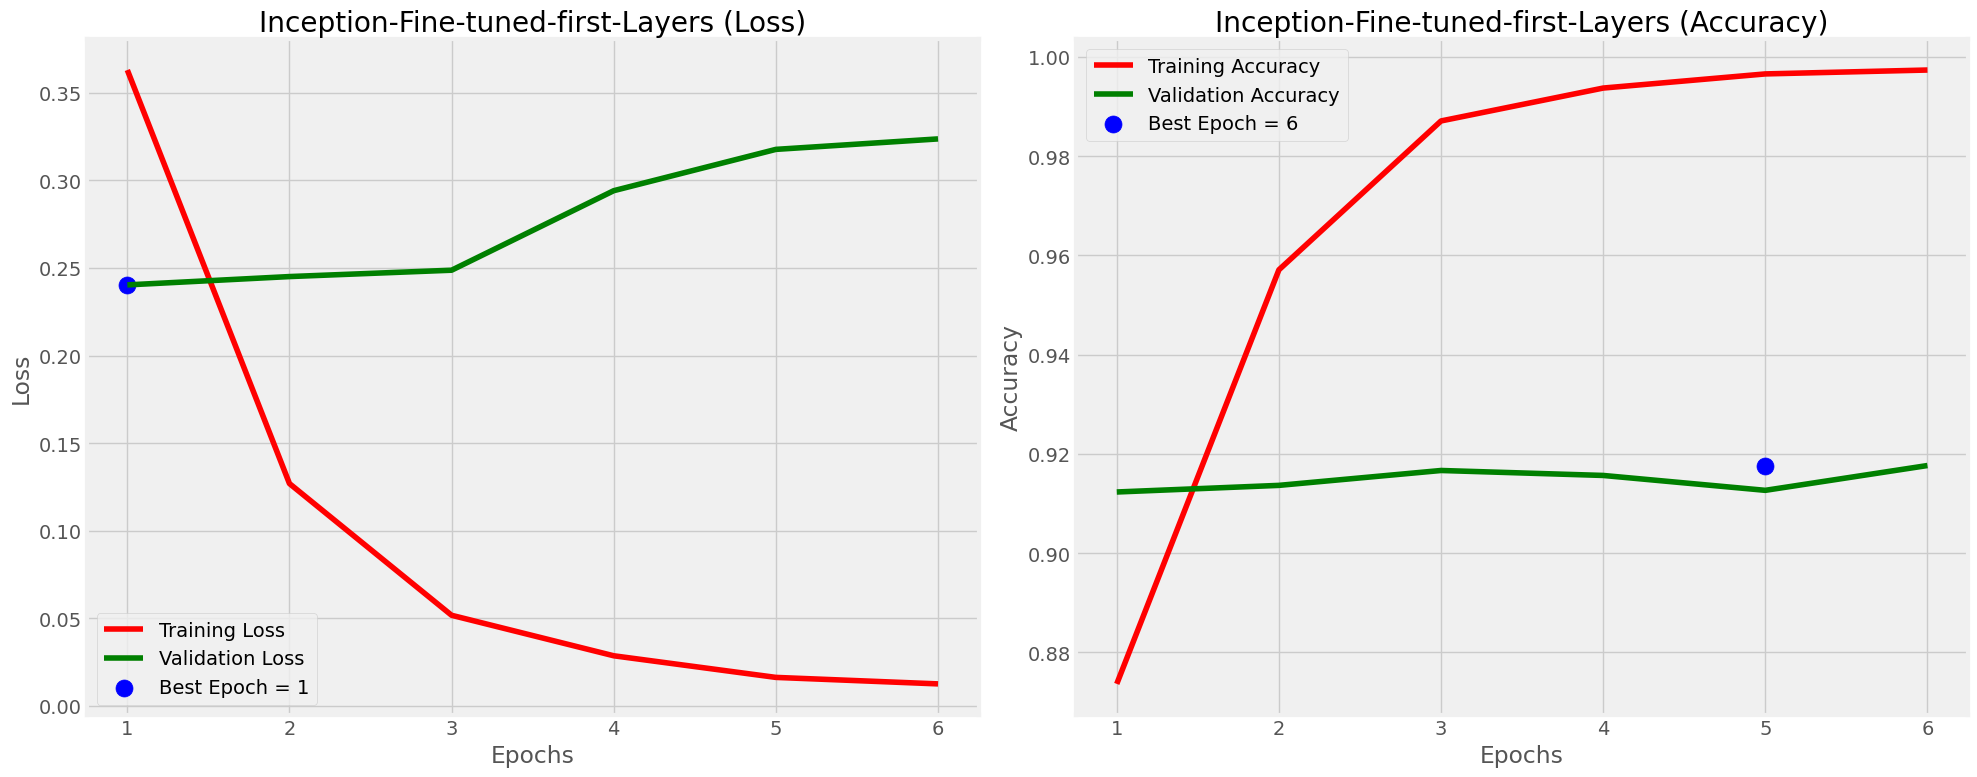

In [37]:
plot_metrics(history5,"Inception-Fine-tuned-first-Layers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


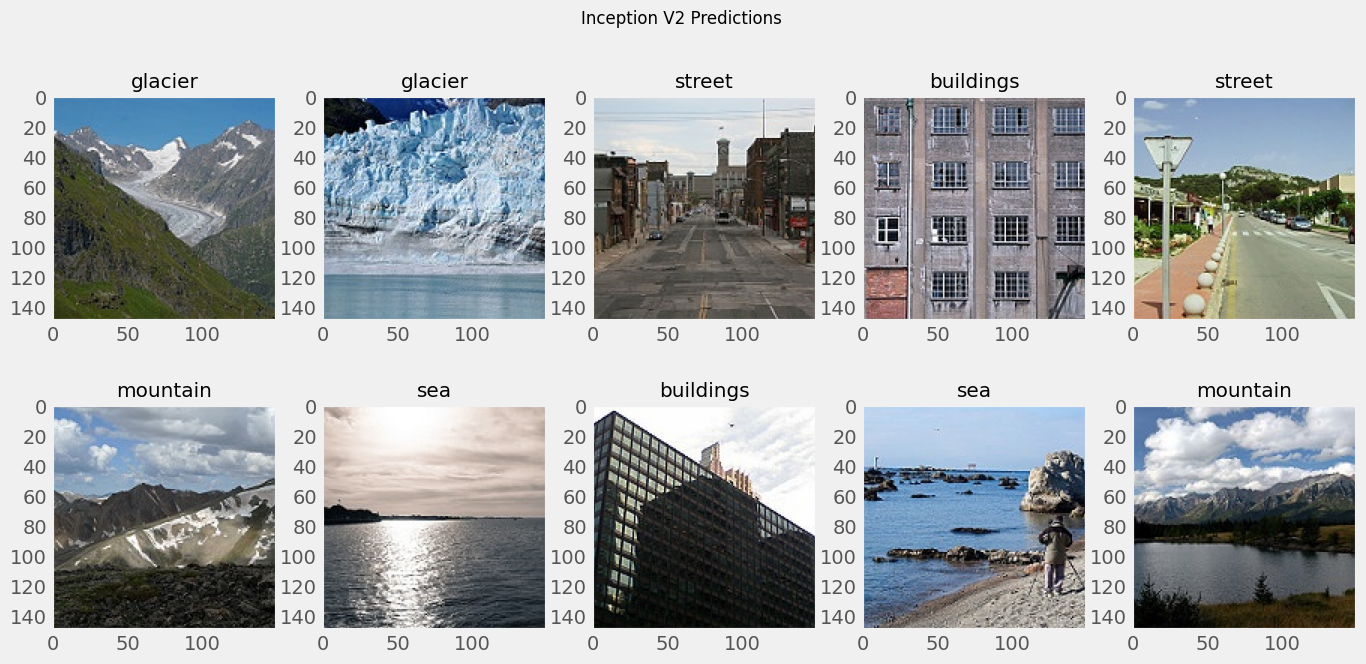

In [38]:
plot_predictions(model5,"Inception V2 Predictions")

## VI - Inception V3

In [39]:
# Load InceptionV3 pre-trained on ImageNet
inception3 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False, pooling= 'max')

model6 = Sequential([
    inception3,
    layers.BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    layers.Dense(256 , activation= 'relu'),
    layers.Dense(128 , activation= 'relu'),
    layers.Dense(6 , activation= 'softmax')
])

In [40]:
# compile the model
model6.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [41]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history6 = model6.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6956 - loss: 0.8342

W0000 00:00:1710761435.684807      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 154s 192ms/step - accuracy: 0.6958 - loss: 0.8336 - val_accuracy: 0.8710 - val_loss: 0.3480
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9030 - loss: 0.2764 - val_accuracy: 0.8900 - val_loss: 0.3001
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9391 - loss: 0.1762 - val_accuracy: 0.9013 - val_loss: 0.2872
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9626 - loss: 0.1178 - val_accuracy: 0.9007 - val_loss: 0.2989
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9701 - loss: 0.0886 - val_accuracy: 0.9030 - val_loss: 0.3051
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9798 - loss: 0.0659 - val_accuracy: 0.9043 - val_loss: 0.3346
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9851 - loss: 0.0483 - val_accuracy: 0.9063 - val_loss: 0.3467
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9870 - loss: 0.0395 - val_accur

In [42]:
model6.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8641 - loss: 0.3825


[0.2871851325035095, 0.9013333320617676]

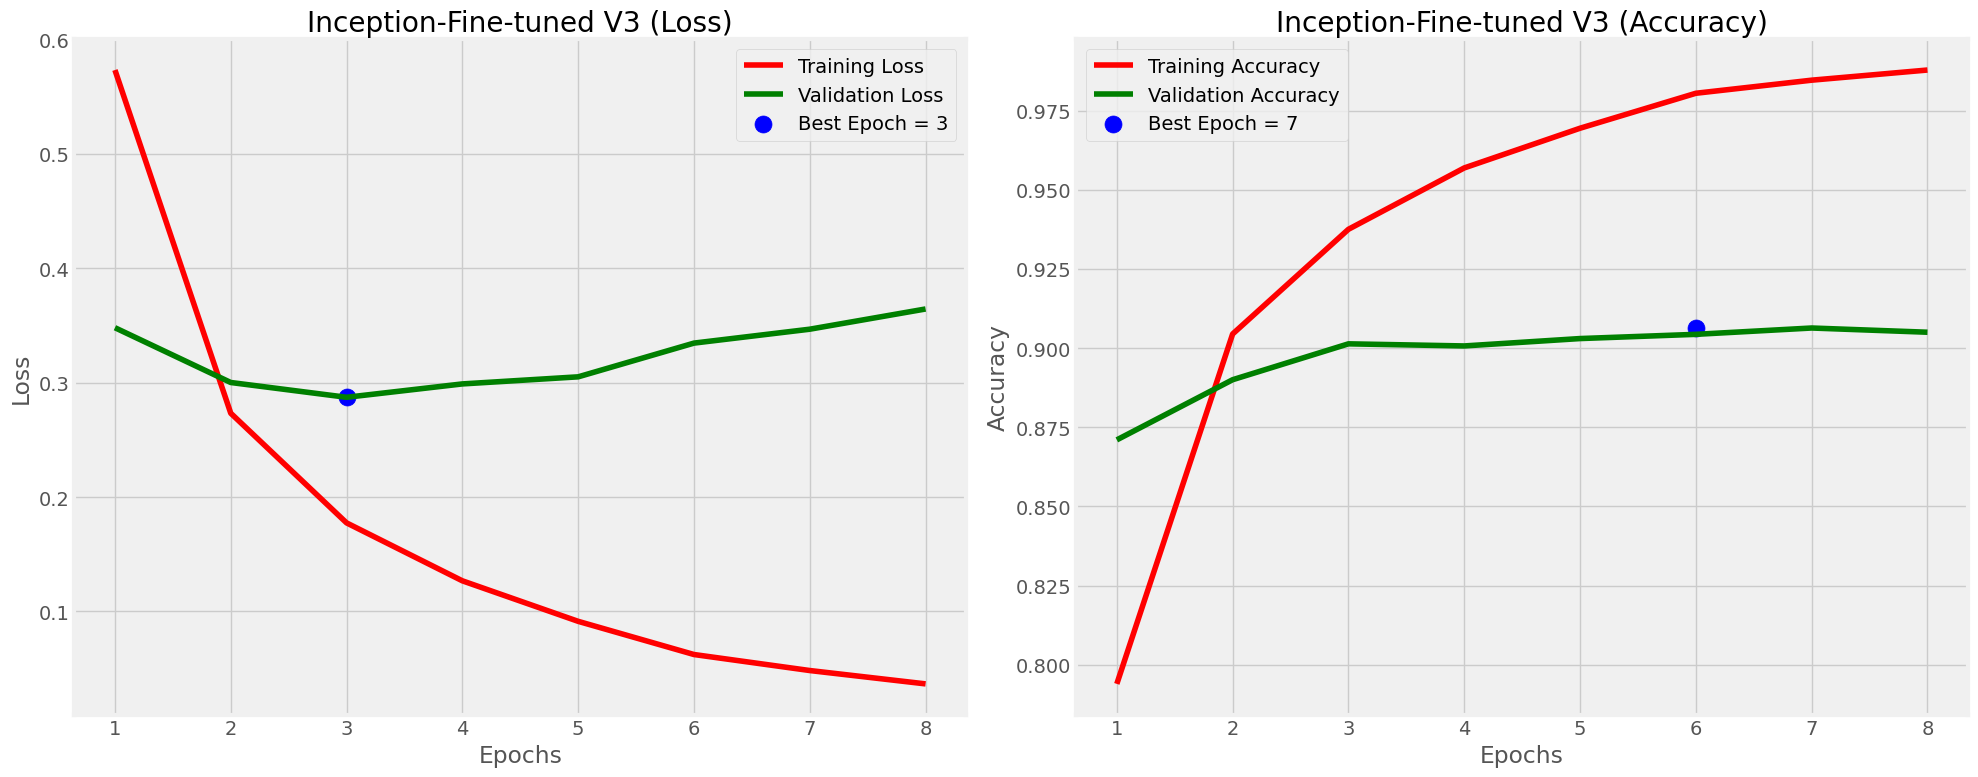

In [43]:
plot_metrics(history6,"Inception-Fine-tuned V3")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


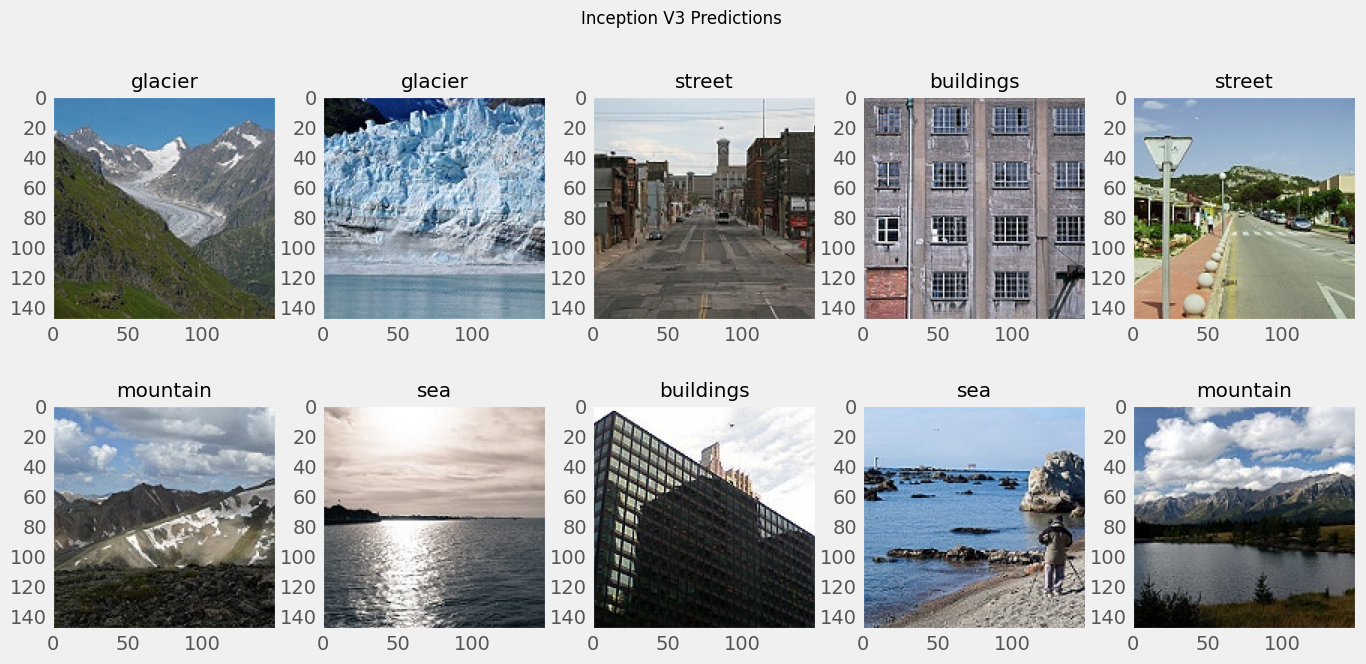

In [44]:
plot_predictions(model6,"Inception V3 Predictions")

# Comparing Models Performances :

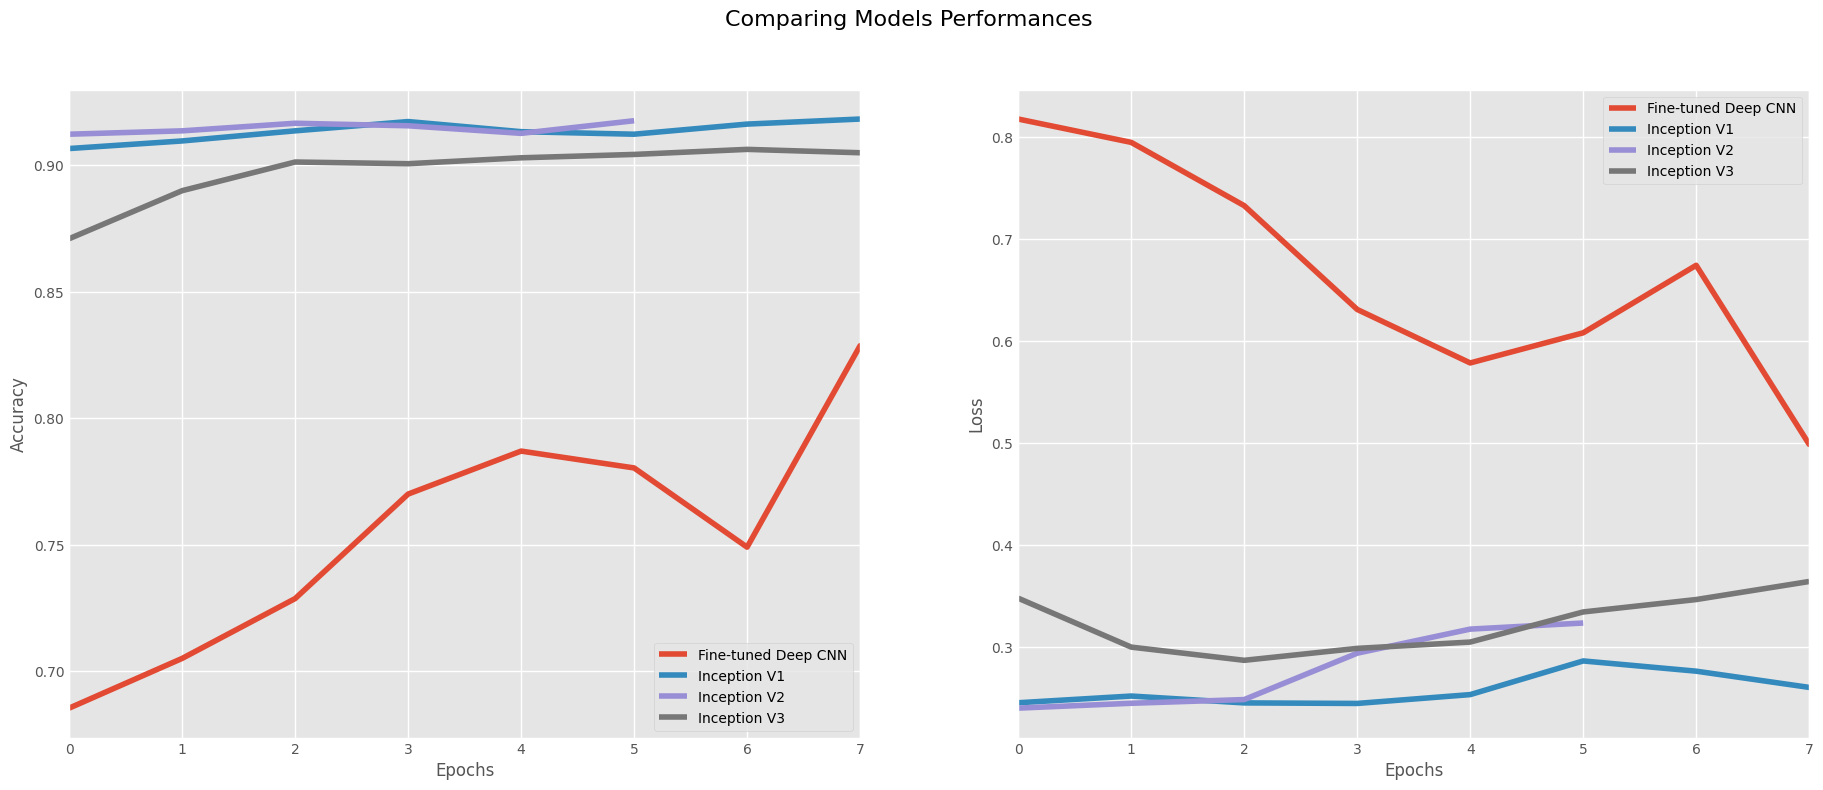

In [45]:
history = [history3,history4,history5,history6]
labels = ["Fine-tuned Deep CNN","Inception V1", "Inception V2", "Inception V3"]
compare_models(history,labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step


W0000 00:00:1710761770.199266      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


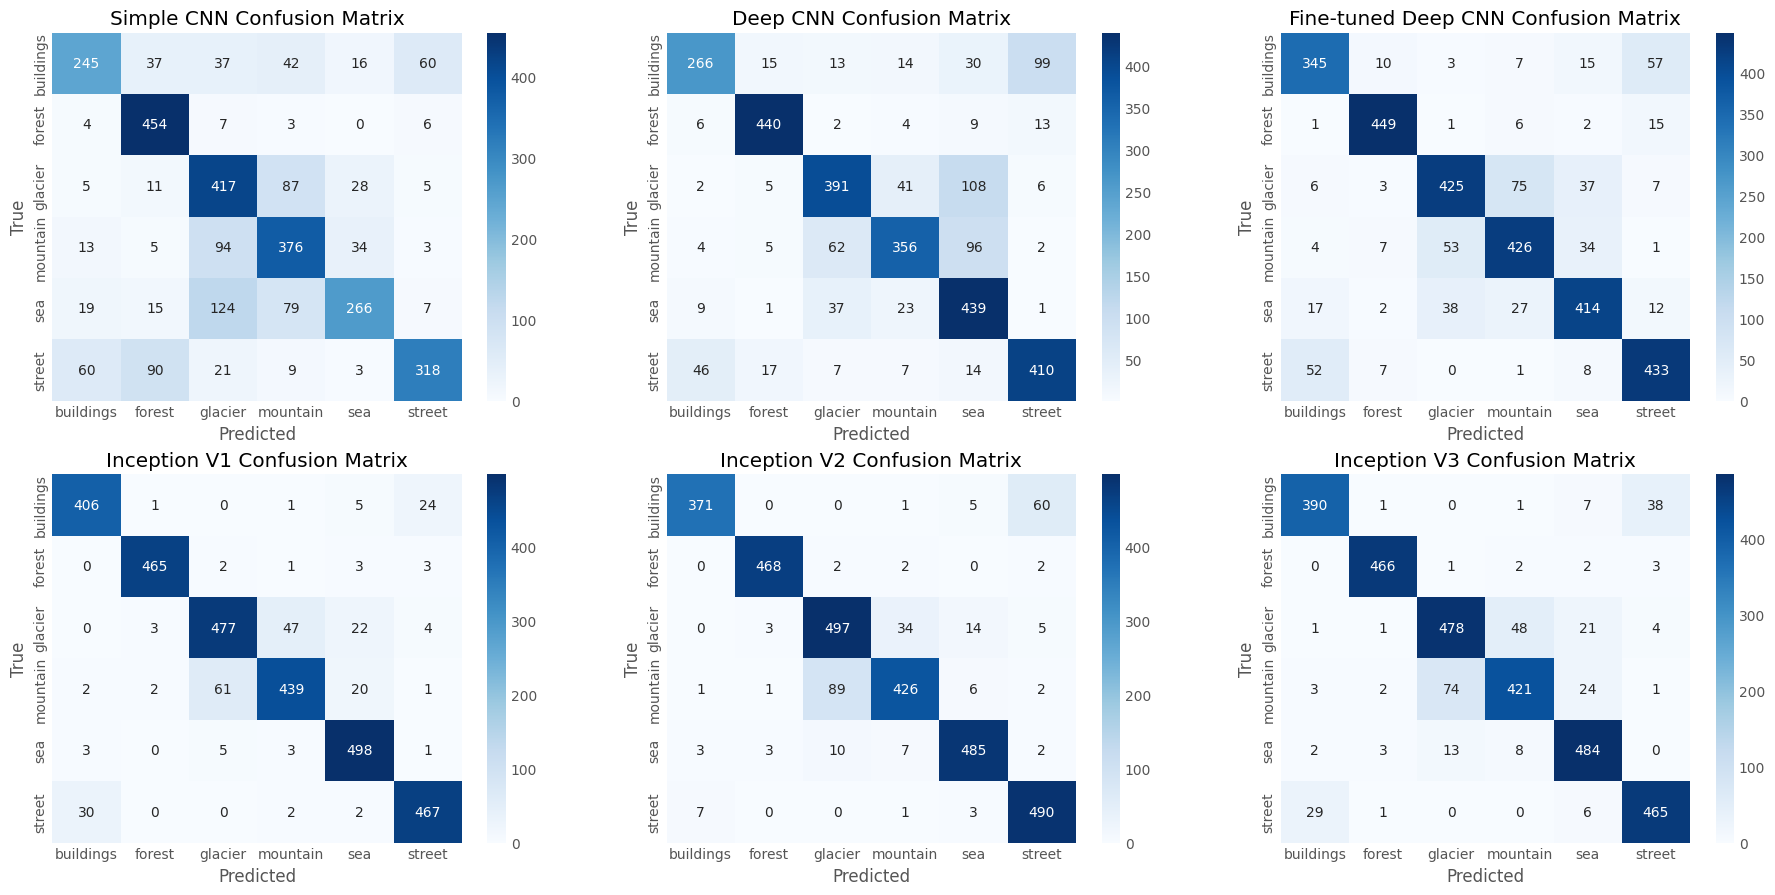

In [46]:
models = [model1,model2,model3,model4,model5,model6]
titles = ["Simple CNN","Deep CNN","Fine-tuned Deep CNN","Inception V1", "Inception V2", "Inception V3"]
compare_conf_mat(models,test_images,test_lab_encoded,titles)

# Saving Models

In [47]:
# saving our model
model1.save('simple_cnn.h5')
model2.save('deep_cnn.h5')
model3.save('ft_deep_cnn.h5')
model4.save('inception_v1.h5')
model5.save('inception_v2.h5')

In [48]:
model6.save('new_inceptionv3.h5')

ValueError: Unable to synchronously create dataset (name already exists)